In [2]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

NameError: name 'library' is not defined

# Overview #
The goal of this project is to create an alorithm that will correctly identify metastatic cancer in image patches taken from different pathology scans.  The data is a modified verstion of the PatchCamelyon (PCam) benchmark dataset that eliminated duplicates.  The benefit of PCam is that models can be easily trained on a single GPU in only a few hours while still getting competitive scores.

The dataset will be loaded first followed by any necessary libraries.  After that, normally there would be some data cleaning but because all repeats have been taken out of the dataset the data clearning will be minimal and only require some column renaming.   

Next, the models will be trained before looking at the overall performance at the end of the project.

## Library and Dataset Load In ##
First the necessary libraries will be loaded in.  The most important library that will be loaded in is Keras Tensorflow.  Tensorflow is an extremely helpful machine learning platform and Keras covers every step of machine learning with a focus on deep learning.  This makes it particularly helpful for this project.  

Other libraries that will be loaded in are pandas, numpy, and matplot to help with organizing and visualizing the data.  

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16


# import other necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
print(os.listdir("../input"))
from shutil import copyfile, move
import h5py
import random

['histopathologic-cancer-detection']


Next, the dataset needs to be loaded in.

In [10]:
#data = pd.read_csv("train_labels.csv")
data = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
print(data.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Based on this information and looking at the dataset in a CSV file, the "0" label indicates a healthy cell while a "1" indicates a cancerous cell.  As a result, I'm going to add a column for the simplicity of data visualization.


In [11]:
# Add '.tif' extension to the 'id' column
data['filename'] = data['id'] + '.tif'

data["correct_cell_type"] = data["label"].apply(lambda x: "Cancer" if x == 1 else "Healthy")
print(data.head())
print(len(data))

# Avoid SettingWithCopyWarning
data = data.copy()

# Convert 'label' column to string type
data['label'] = data['label'].astype(str)

                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                       filename correct_cell_type  
0  f38a6374c348f90b587e046aac6079959adf3835.tif           Healthy  
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif            Cancer  
2  755db6279dae599ebb4d39a9123cce439965282d.tif           Healthy  
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif           Healthy  
4  068aba587a4950175d04c680d38943fd488d6a9d.tif           Healthy  
220025


Next, it's time to split the data between training and testing sets.  This training set is going to be 75% of the dataset while the remaining 25% will be the testing sets.  

There are 220025 pieces of data in this dataset.  Therefore, there will be 165019 pieces of data in the training data and 55006 in the testing data.  

In [12]:
# training and testing set sizes
training_size = 165019
testing_size = 55006

# create testing sets
training_data = data.sample(n=training_size)

# make sure that the testing data doesn't take data that's already been taken by the training data
testing_data = data[~data.index.isin(training_data.index)]

# check each
print(training_data.head())
print(training_data.info())

                                              id label  \
122147  93ad8fc2d13bed0fad0f0c2d243ca7c2d0c596af     0   
15648   054ceddcbc5fb5dced5770562d8aa1f5f1fadefe     1   
49983   a435bf2f01f157a7b248dd30b67be09112b3b4c2     0   
68823   bea0b41785c5150b05499711779d4419df9fc7bb     0   
30002   345cd8594dde5a35e0773271ebe250b625a17842     0   

                                            filename correct_cell_type  
122147  93ad8fc2d13bed0fad0f0c2d243ca7c2d0c596af.tif           Healthy  
15648   054ceddcbc5fb5dced5770562d8aa1f5f1fadefe.tif            Cancer  
49983   a435bf2f01f157a7b248dd30b67be09112b3b4c2.tif           Healthy  
68823   bea0b41785c5150b05499711779d4419df9fc7bb.tif           Healthy  
30002   345cd8594dde5a35e0773271ebe250b625a17842.tif           Healthy  
<class 'pandas.core.frame.DataFrame'>
Index: 165019 entries, 122147 to 139938
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id

In [13]:
print(testing_data.head())

                                          id label  \
1   c18f2d887b7ae4f6742ee445113fa1aef383ed77     1   
2   755db6279dae599ebb4d39a9123cce439965282d     0   
5   acfe80838488fae3c89bd21ade75be5c34e66be7     0   
11  c3d660212bf2a11c994e0eadff13770a9927b731     1   
18  730431efa2f79927156dcc4382819e9a6cc2c5bb     0   

                                        filename correct_cell_type  
1   c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif            Cancer  
2   755db6279dae599ebb4d39a9123cce439965282d.tif           Healthy  
5   acfe80838488fae3c89bd21ade75be5c34e66be7.tif           Healthy  
11  c3d660212bf2a11c994e0eadff13770a9927b731.tif            Cancer  
18  730431efa2f79927156dcc4382819e9a6cc2c5bb.tif           Healthy  


The ImageDataGenerator from keras is part of tensorflow and is extremely helpful for tensor image data.  The data augmentation can happen in real time and there are lots of Args that you can adjust with it. 

Based on what was said in kaggle, the 32x32 pixel area that is in the center of the 96x96 pixel images can contain cancer cells.  Nowhere else.  

In [14]:
import os



# Convert 'label' column to string type
data['label'] = data['label'].astype(str)

# Print some information for debugging
#print("Sample paths from 'id_with_extension' column:")
#print(data['id_with_extension'].head())

datagen_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25)

train_gen = datagen_train.flow_from_dataframe(
    dataframe=data,
    x_col='filename',
    y_col='label',
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    target_size=(96, 96),
    subset='training',
    batch_size=10,
    shuffle=True,
    class_mode='binary')

val_gen = datagen_train.flow_from_dataframe(
    dataframe=data,
    x_col='filename',  # Use the new column
    y_col='label',
    directory = '/kaggle/input/histopathologic-cancer-detection/train',
    target_size=(96, 96),
    subset = 'validation',
    batch_size=10,
    shuffle=True,
    class_mode='binary')

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Model Creation CNN with Keras ##
With the training and validation sets ready, the model needs to be created in order to get our results.  VGG16 is going to be used because it is an ideal source when working with visual model detection and is 16 layers deep.  VGG16 will also be fast to train in comparsion to others.  

This first model is a CNN model using Keras.  

In [15]:
pretrained_layers = VGG16(weights = 'imagenet', include_top = False, input_shape = (96, 96, 3), classes = 1000)
pretrained_layers.summary()

# special note- input_shape must be this value because of the size of our images being 96x96

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

As you can see, the output shape continues to grow in the third column.  The input shape starting out at 96x96 is fine for what we need with our images.  It doesn't need to expand beyond that.  

Time to go through and see which layer to freeze would help see the best way to optimize the model's performance.

Epoch 1/3
16501/16501 [==============================] - 1040s 63ms/step - loss: 25.7453 - accuracy: 0.5946 - val_loss: 0.6748 - val_accuracy: 0.5955
Epoch 2/3
16501/16501 [==============================] - 1099s 67ms/step - loss: 0.6751 - accuracy: 0.5948 - val_loss: 0.6748 - val_accuracy: 0.5955
Epoch 3/3
16501/16501 [==============================] - 1098s 67ms/step - loss: 0.6751 - accuracy: 0.5948 - val_loss: 0.6749 - val_accuracy: 0.5955


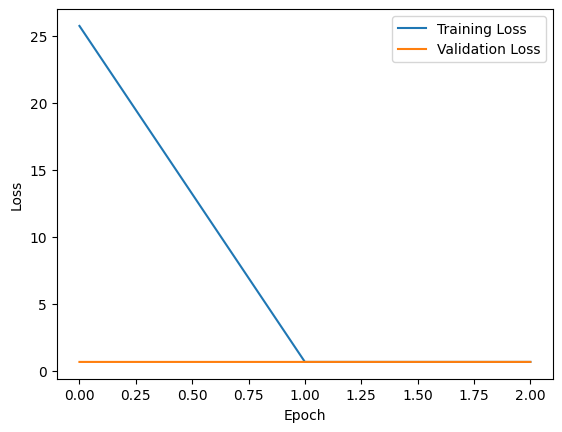

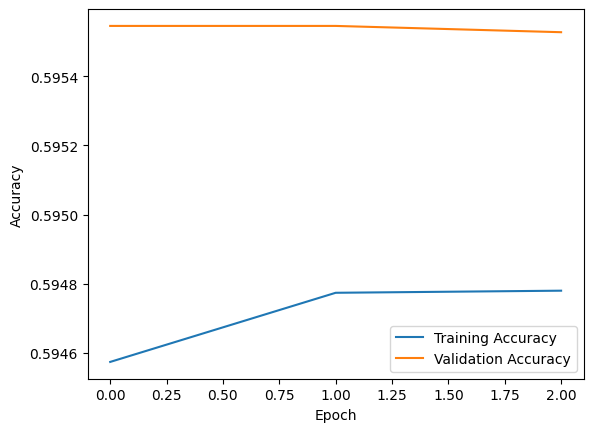

In [18]:
for layer in pretrained_layers.layers[:-10]:
    layer.trainable = False
    
model = Sequential()
model.add(pretrained_layers)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# see how the model performs
history = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    epochs = 3,
    validation_data = val_gen,
    validation_steps = val_gen.samples // val_gen.batch_size
)

# plot results out
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This was using a CNN model with Keras.  The model it will be compared to is the EfficientNetB0 which is noticeably different than CNN because there is fewer parameters in comparison.  

/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/3


2024-02-02 21:30:27.634105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16501/16501 [==============================] - 2586s 156ms/step - loss: 0.3745 - accuracy: 0.8374 - val_loss: 0.3219 - val_accuracy: 0.8655
Epoch 2/3
16501/16501 [==============================] - 1129s 68ms/step - loss: 0.3252 - accuracy: 0.8615 - val_loss: 0.3009 - val_accuracy: 0.8739
Epoch 3/3
16501/16501 [==============================] - 980s 59ms/step - loss: 0.3111 - accuracy: 0.8689 - val_loss: 0.2846 - val_accuracy: 0.8827


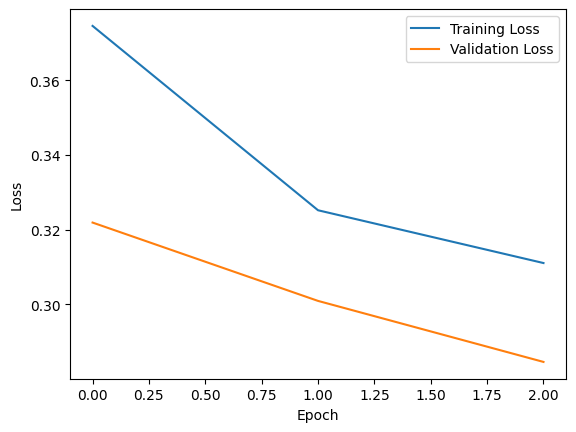

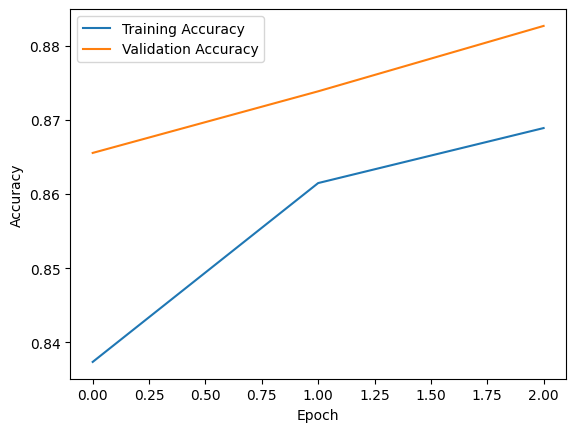

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


# Load EfficientNetB0 with pre-trained weights
pretrained_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the layers up to the last 10 layers
for layer in pretrained_layers.layers[:-10]:
    layer.trainable = False

# Create your model
model = Sequential()
model.add(pretrained_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=3,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size
)

# Plot results
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save('efficientnetb0_cancer_detection_model.h5')

Based on what can be seen from the following graphs, It is best to stick with the EfficentNetB0 model.  The CNN did not have the same accuracy.  

## Run on test data ##
Using the EfficientNetB0 model, this will be used on the testing data to then submit to Kaggle

In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
loaded_model = load_model('efficientnetb0_cancer_detection_model.h5')

# Specify the test data directory
test_data_directory = '/kaggle/input/histopathologic-cancer-detection'

# Create an ImageDataGenerator for test data )
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Flow from directory for test data
test_gen = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(96, 96),
    batch_size=10,
    class_mode=None,  
    shuffle=False,
    classes = ['test']
)

# Extract file names from generator
file_list = [file.split('/')[-1] for file in test_gen.filenames]

# Create a DataFrame with filenames
test_df = pd.DataFrame({'id': file_list})

# Predict using the model
predictions = loaded_model.predict(test_gen, steps=len(test_gen), verbose=1)

# Create a DataFrame with filenames and predicted probabilities
result_df = pd.DataFrame({
    'id': test_df['id'].apply(lambda x: x.split('.')[0]),
    'label': predictions.flatten()
})

# Add a column for predicted labels based on a threshold 
result_df['predicted_label'] = result_df['label'].apply(lambda x: 1 if x >= 0.5 else 0)

# Save the DataFrame to a CSV file
result_df[['id', 'predicted_label']].to_csv('test_predictions.csv', index=False)

Found 57458 images belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


5746/5746 [==============================] - 102s 17ms/step


In [47]:
print(result_df.head())                                  

                                         id     label  predicted_label
0  00006537328c33e284c973d7b39d340809f7271b  0.996223                1
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.769609                1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.999999                1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.889917                1
4  000270442cc15af719583a8172c87cd2bd9c7746  0.158483                0


In [48]:
result_df = result_df.drop('label', axis=1)
print(result_df.head())

                                         id  predicted_label
0  00006537328c33e284c973d7b39d340809f7271b                1
1  0000ec92553fda4ce39889f9226ace43cae3364e                1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2                1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6                1
4  000270442cc15af719583a8172c87cd2bd9c7746                0


In [49]:
result_df = result_df.rename(columns={'predicted_label': 'label'})


print(result_df.head())

                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      1
4  000270442cc15af719583a8172c87cd2bd9c7746      0
